# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В ходе исследования проверим влияение различных факторов на конечную цену недвижимости.\
План работы:
1) Провести предобработку данных: заполнить или удалить пропущенные значения, исследовать аномалии, удалить неявные дубликаты, создать новые столбцы;
2) Изучить все параметры недвижимости путем построения гистограмм;
3) Изучить, как быстро продавались квартиры;
4) Выявить какие факторы влияют на стоимость квартиры;
5) Посчитаь цену одного квадратного метра;
6) Посчитать среднюю цену одного километра до центра города;
7) Сделать общий вывод.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Ознакомимся с исходными данными таблицы:

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В исходных данных 23699 строк и 22 столбца. Построим общую гистограмму для всех числовых столбцов таблицы.

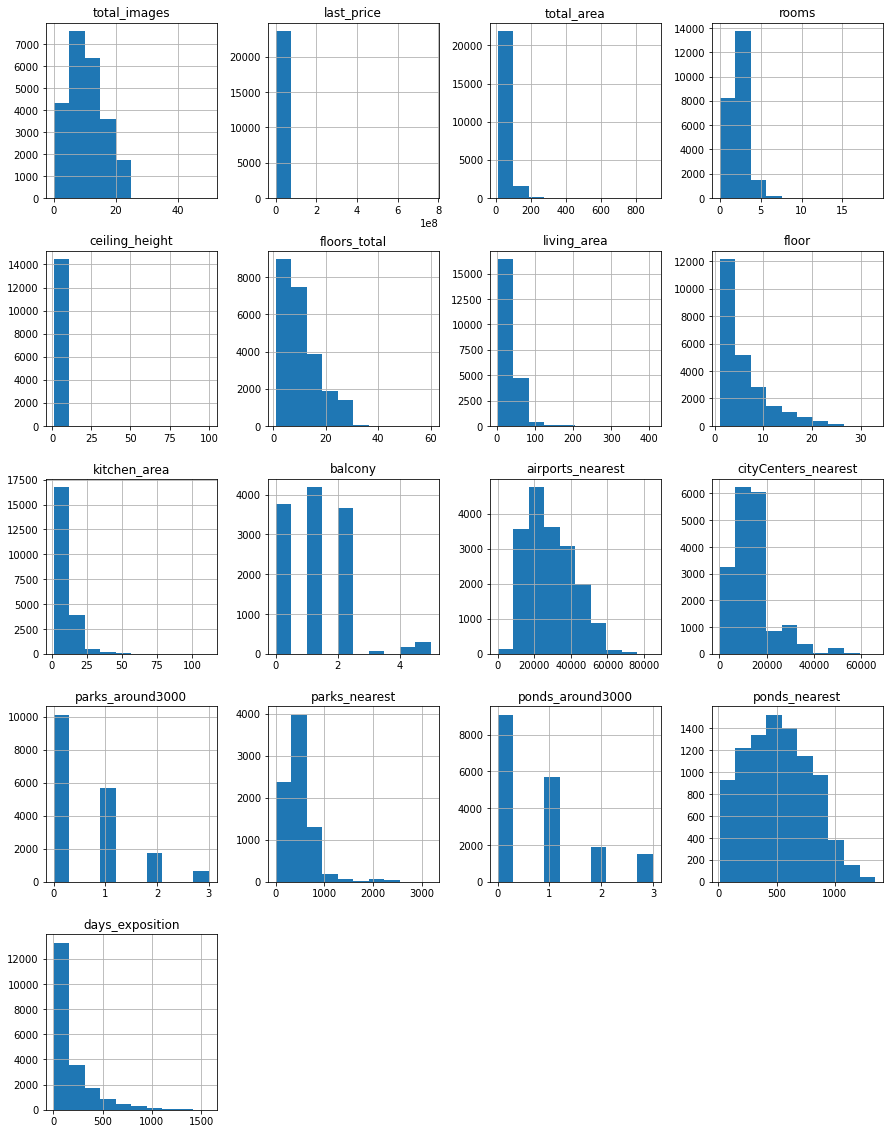

In [4]:
data.hist(figsize=(15,20));

Не все данные понятны с первого знакомства с ними, но они дают представление о ситуации и закономерностях на рынке недивжимости, например какое количество комнат в квартирах, которые выставлены на продажу, их площадь, а также какая инфраструктура вблизи объектов.

### Предобработка данных

**Работа с пропусками**\
Найдем и изучим пропущенные значения в столбцах. Для начала определим в каких столбцах есть пропуски.

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В исходных данных много пропусков. В столбце is_apartment пропусков почти столько же, сколько строк в таблице. Очень много пропусков в столбцах с расстояниями до парков и водоемов, скорее всего, эти значения не указывались из-за того, что рядом их нет. Аналогично с балконами. 9195 пропусков в столбце с высотой потолков, природа этих пропусков непонятна, их предстоить заполнить медианным значением, так как данные важны для анализа. Так же есть пропуски, но их меньше, в колонках floors_total, living_area, kitchen_area, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000, days_exposition. Попробуем заполнить пропущенные значения, где это возможно.

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

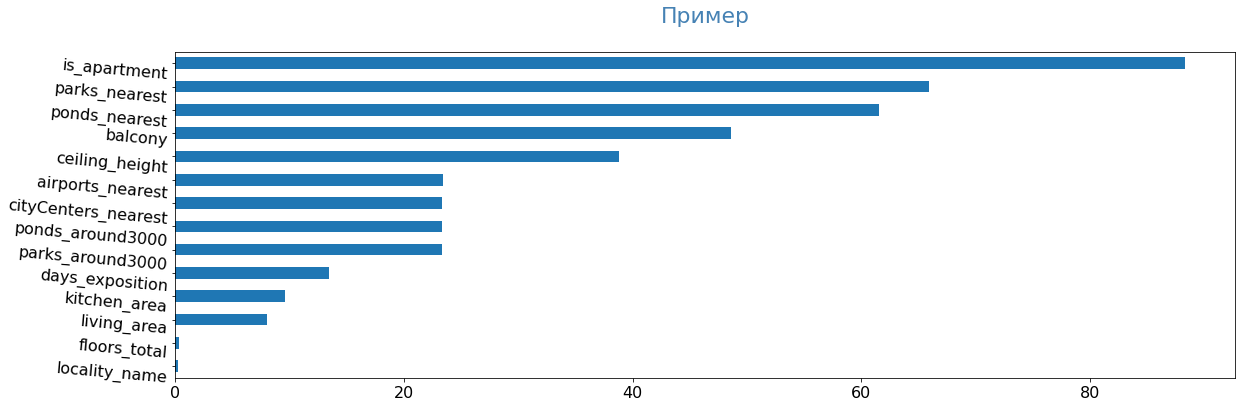

In [7]:
pass_value_barh(data)

Удалим строки с пропущенными значениями в столбце floors_total. Их не очень много, поэтому это не повлияет на ход исследования.

In [8]:
data.dropna(subset=['floors_total'], inplace=True)

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(True)

Так как столбец is_apartment показывает, является ли продаваемая недвижимость апартаментами, можно предположить, что пропущенные значения соответствуют значению True, то есть владелец не указывал такой тип недвижимости, потому что, возможно, и так понятно, что это квартира. Далее заполним пропуски в столбце balcony.

In [10]:
data['balcony'] = data['balcony'].fillna(0)

Пропуски в столбце balcony были заполнены значением 0, так как можно предположить, что продавцы не указывали количество балконов, в случае если их нет в квартире.

Пропуски в столбцах с расстоянием до парка или водоема заполнять некорректно, так как мы не можем с уверенностью предположить, что они есть рядом. Тогда ни нулевое, ни медианное значение не подойдет.

In [11]:
data['ceiling_height'] = data['ceiling_height'].transform(lambda x: x.fillna(x.median()))

Заполним пропуски в столбце высоты квартиры медианным значением. В данном случае не можем сгруппировать данные по населенному пункту или чилу этажей, так как могут быть не достоверными.

Можем так же предположить, что квартиры, в которых не указано количество парков и водоемов в радиусе 3 км, не имеют их рядом, тогда пропускам в этом столбце можно присвоить значение 0. 

In [12]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Посмотрим, как изменилось количество пропусков после заполнения некоторых из них:

In [13]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000            0
parks_nearest           15568
ponds_around3000            0
ponds_nearest           14552
days_exposition          3172
dtype: int64

Пропусков стало действительно меньше, но если заполнить остальные, то можем получить недостоверные данные. Пропуски в столбцах, обозначающих расстояния до объектов: парков, водоемов, центра города, аэропорта, могли образоваться либо из-за того, что рядом нет соответствующих объектов или же продавец решил, что указывать расстояние не нужно, так как оно не повлияет на привлекательность объявления, например, если оно слишком большое. Причины появления пропусков в колонках с площадью квартиры непонятны, так как это один из ключевых показателей для покупателя недвижимости. Пропуски в столбце площади кухни могли быть пропущены, если квартира имеет необычную планировку, например квартира студия или квартира с совмещенной кухней и гостинной. Пропущенных значений в колонках, отражающих количество этажей в доме и названия населенного пункта, мало по сравнению с общим числом строк, поэтому они не исказят исследование.  

**Типы данных**\
Далее рассмотрим тип данных в каждом столбце:

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21743 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          21382 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Дата публикации (first_day_exposition) имеет тип данных object. Можем перевести в тип datetime:

In [15]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')

Столбец balcony, отражающий количество балконов в квартире, имеет тип данных float64, изменим его на целочисленный:

In [16]:
data['balcony'] = data['balcony'].astype('int')

Аналогично поступим и с количеством парков и водоемов в радиусе 3км и количеством этажей в доме:

In [17]:
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

In [18]:
data['floors_total'] = data['floors_total'].astype('int')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

Мы изменили типы данных нескольких столбцов. Дата публикации была изменена, так как формат datetime будет удобен в дальнейшем по сравнению с типом данных object. Так же изменили тип столбцов с количеством балконов в квартире и парков и водоемов рядом, так как их значения должны быть целочисленными.

**Поиск дубликатов**\
Изучим уникальные значения в столбце locality_name:

In [20]:
print('Кол-во уникальных значений:', data['locality_name'].nunique())
data['locality_name'].unique()

Кол-во уникальных значений: 364


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

В названиях населенных пунктов встречается поселок, посёлок, поселок городского типа и городской поселок. Приведем все к "поселок" для избежания повторов. Для начала приведем все к нижнему регистру и заменим ё на е.

In [21]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё','е')
print('Новое кол-во уникальных значений:', data['locality_name'].nunique())

Новое кол-во уникальных значений: 330


Оставим только названия населенных пунктов без указания его вида: деревня, село, поселок и тд:

In [22]:
wrong_names = ['поселок','городской', 'городского типа', 'станции', 'коттеджный', \
               'деревня','при железнодорожной','село','садовое товарищество',\
               'садоводческое некоммерческое товарищество']
for wrong_name in wrong_names:
    data['locality_name'] = data['locality_name'].str.replace(wrong_name, '')
data['locality_name'] = data['locality_name'].str.lstrip()
data['locality_name'].nunique()

305

Таким образом, количесто уникальных значений снизилось с 364 до 305. Неявные дубликаты были выявлены и заменены.

In [23]:
data['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'федоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное ', 'понтонный', 'сясьстрой',
       'старая', 'лесколово', 'новый свет', 'сланцы', 'путилово',
       'ивангород', 'шлиссельбург', 'никольское', 'зеленогорск',
       'сосновый бор', 'оржицы', 'кальтино', 'романовка', 'бугры',
       'рощино', 'кириши', 'луга', 'волосово', 'отрадное', 'павлово',
       'оредеж', 'копорье', 'молодежное', 'тихвин', 'победа', 'нурма',
       'синявино', 'тосно', 'стрельна', 'бокситогорск', 'ал

**Обработка аномальных значений**

Исслудуем столбцы датафрейма на наличие аномальных значений. Начнем с количества комнат:

In [24]:
data['rooms'].value_counts()

1     8015
2     7913
3     5795
4     1177
5      325
0      194
6      104
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Квартир, где количество комнат 8 и более, очень мало по сравнению с общим числом объявлений. Эти строки можно удалить, так как на исследование они не повлияют.

In [25]:
index = data[data['rooms'] >= 8].index
data.drop(index, inplace=True)

Удалим аномальные значения высоты потолка:

In [26]:
potolok = data[(data['ceiling_height'] <= 2.40) | (data['ceiling_height'] >= 4.00)].index
data.drop(potolok, inplace=True)

Аналогично поступим с площадью квартир. Квартир с площадью менее 15 кв.м очень мало, их отсутсвие не повлияет на исследование, так же, как и слишком большие квартиры площадью более 200 кв.м. Такие значения близки к аномальным.

In [27]:
# check
data.shape[0]

23425

In [28]:
area = data[(data['living_area'] <= 15.00) | (data['living_area'] >= 200.00)].index
data.drop(area, inplace=True)

In [29]:
# check
data.shape[0]

22397

In [30]:
tot_area = data[(data['total_area'] <= 20.00) | (data['total_area'] >= 250.00)].index
data.drop(tot_area, inplace=True)

In [31]:
# check
data.shape[0]

22312

Можно предположить, что квартиры которые продаются больше 1200 дней-аномальный случай, аналогично с квартирами, "висящими" на сайте менее 5 дней. Таких объявлений мало, мы можем их так же удалить:

In [32]:
fake_days = data[(data['days_exposition'] <= 0.00) | (data['days_exposition'] >= 1200.00)].index
data.drop(fake_days, inplace=True)

In [33]:
# check
data.shape[0]

22225

Конечная цена на квартиры так же вызывает вопросы

<AxesSubplot:>

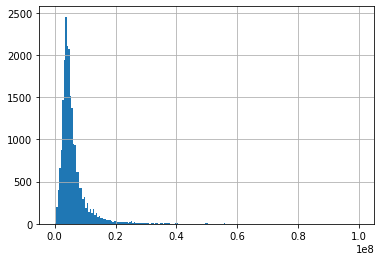

In [34]:
data['last_price'].hist(bins=200, range=(0,100000000))

Удалим квартиры дешевле 1млн и дороже 200 млн рублей:

In [35]:
flat_price = data[(data['last_price'] <= 1000000) | (data['last_price'] >= 200000000)].index
data.drop(flat_price, inplace=True)

In [36]:
# check
data.shape[0]

21986

Предположим, что "нормальная" площадь кухни: 5-50 кв м. Остальные будем считать аномальными.

In [37]:
kitchen = data[(data['kitchen_area'] <= 4.00) | (data['kitchen_area'] >= 50.00)].index
data.drop(kitchen, inplace=True)

In [38]:
# check
data.shape[0]

21904

На данный момент самым высоким жк в Петербурге является ЖК «Князь Александр Невский», в котором 37 этажей. Значения больше данного можем удалить.

In [39]:
floors_tot = data[data['floors_total'] >= 38].index
data.drop(floors_tot, inplace=True)

Остальные данные тоже вызывают вопросы, например, 5 балконов в квартире или маленькая площадь кухни. Но не будем удалять эти значения, чтобы не лишаться ценной информации. Стоит в дальнейшем рассмотреть такие объекты детальнее.

#### check gap

In [40]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21903 entries, 0 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21903 non-null  int64         
 1   last_price            21903 non-null  float64       
 2   total_area            21903 non-null  float64       
 3   first_day_exposition  21903 non-null  datetime64[ns]
 4   rooms                 21903 non-null  int64         
 5   ceiling_height        21903 non-null  float64       
 6   floors_total          21903 non-null  int64         
 7   living_area           20125 non-null  float64       
 8   floor                 21903 non-null  int64         
 9   is_apartment          21903 non-null  bool          
 10  studio                21903 non-null  bool          
 11  open_plan             21903 non-null  bool          
 12  kitchen_area          19860 non-null  float64       
 13  balcony         

In [41]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,903.00","21,903.00","21,903.00","18,941.00","21,903.00","20,125.00","19,860.00","21,903.00","21,903.00"
min,0.00,20.10,2.45,1.00,"1,010,000.00",15.01,4.10,1.00,1.00
max,7.00,249.00,3.98,"1,199.00","160,000,000.00",184.00,49.40,33.00,36.00


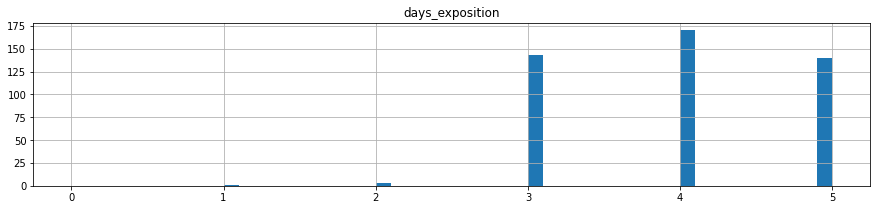

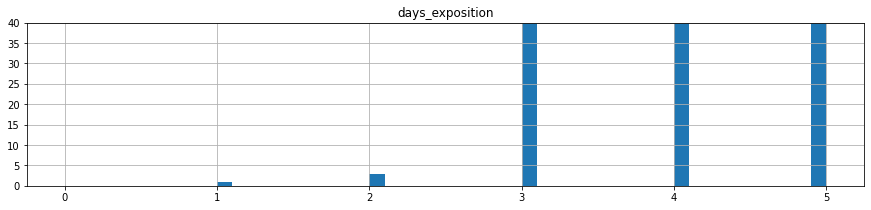

In [42]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [43]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [44]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


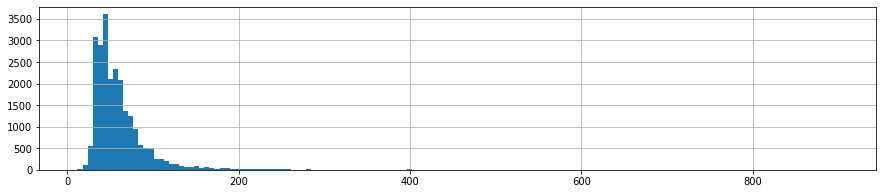

In [45]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

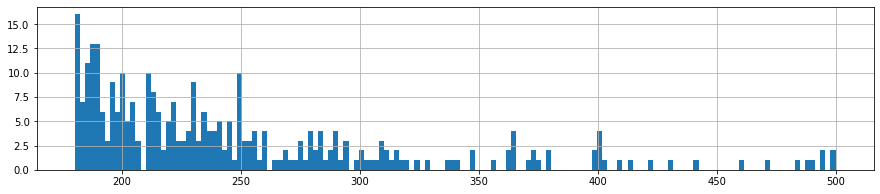

In [46]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

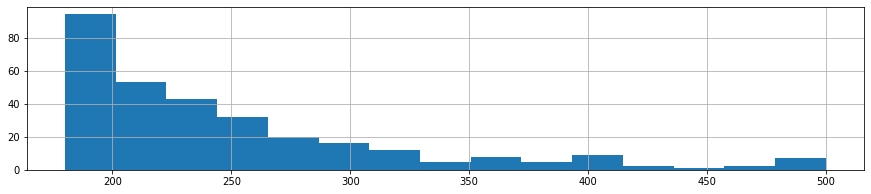

In [47]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

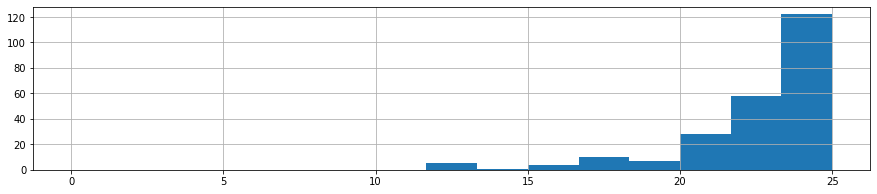

In [48]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [49]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,23.00,2.48,3.00,"1,072,824.00",15.10,4.80,1.00,2.00
0.01,1.00,27.55,2.50,4.00,"1,300,000.00",15.40,5.00,1.00,2.00
0.5,2.00,53.30,2.65,95.00,"4,700,000.00",30.70,9.00,4.00,9.00
0.99,5.00,170.00,3.50,979.60,"29,000,000.00",103.08,32.00,22.00,26.00
0.9988,7.00,230.00,3.80,"1,161.54","67,000,000.00",153.70,44.12,26.00,28.00


### Посчитайте и добавьте в таблицу новые столбцы

1) Найдем цену одного квадратного метра и добавим этот столбец в исходную таблицу:

In [50]:
data['metеr_price'] = data['last_price'] / data['total_area']
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metеr_price
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,True,...,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.60,1,True,...,2,шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.30,4,True,...,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,NaN,9,True,...,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,True,...,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,NaN,22,True,...,2,санкт-петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,110544.692737
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.43,26,True,...,0,мурино,NaN,NaN,0,NaN,0,NaN,189.0,87454.764777
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,True,...,2,санкт-петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,88524.590164
10,5,5050000.0,39.60,2017-11-16,1,2.67,12,20.30,3,True,...,0,санкт-петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.252525
11,9,3300000.0,44.00,2018-08-27,2,2.65,5,31.00,4,False,...,1,ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0,75000.000000


2) Создадим столбец с днем недели публикации (понедельник-0, вторник-1 и так далее):

In [51]:
data['weekday'] = data['first_day_exposition'].dt.weekday

3) Так же найдем и добавим месяц и год публикации объявления:

In [52]:
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

4) Добавим столбец с типом этажа, поделив их на первый, последний и другой:

In [53]:
def floor_type(data):
    if data['floor'] == 1:
        return 'первый'
    if data['floor'] == data['floors_total']:
        return 'последний'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1)

5) И наконец, добавим столбец, показывающий расстояние до центра города в километрах

In [54]:
data['centre_km'] = round(data['cityCenters_nearest'] / 1000)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metеr_price,weekday,month,year,floor_type,centre_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,True,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

Построим гистограммы для каждого параметра
1. Общая площадь

<AxesSubplot:>

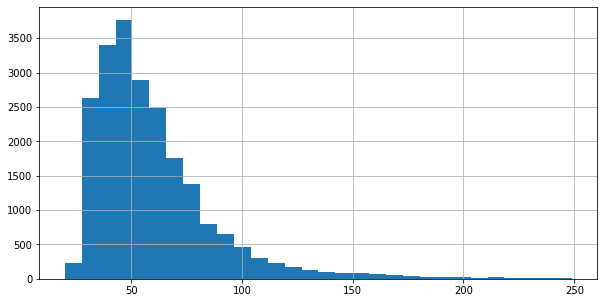

In [55]:
data['total_area'].hist(figsize=(10,5), bins=30)

Больше всего квартир 40-70 кв.м. Квартиры площадью менее 100 кв.м составляют малую долю среди всех квартир.\
2. Жилая площадь

<AxesSubplot:>

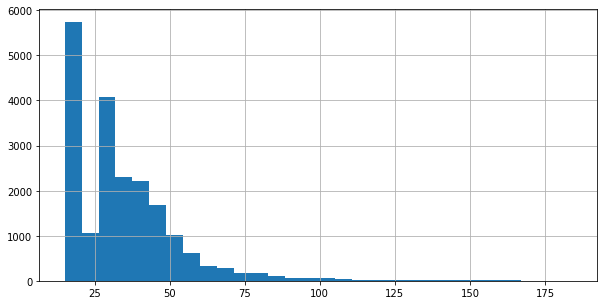

In [56]:
data['living_area'].hist(figsize=(10,5), bins=30)

Самая часто встречающаяся жилая площадь ~ 15 кв.м. Далее ~ 30 кв.м. Квартиры с жилой площадью более 50 кв.м. встречаются редко.\
3. Площадь кухни

<AxesSubplot:>

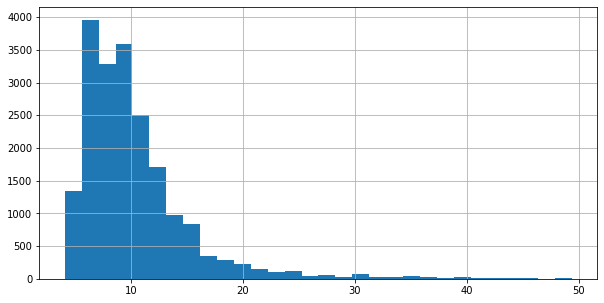

In [57]:
data['kitchen_area'].hist(figsize=(10,5), bins=30)

Самая распространенная площадь кухни от 5 до 10 кв.м. Кухни площадью более 15 кв.м. редко продают.\
4. Цена объекта

<AxesSubplot:>

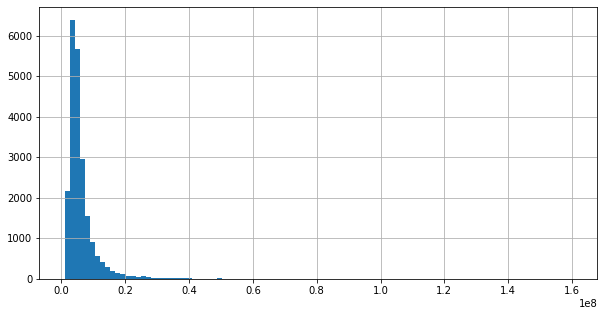

In [58]:
data['last_price'].hist(figsize=(10,5), bins=100)

График не понятен, но очень интересен.\
5. Количество комнат

<AxesSubplot:>

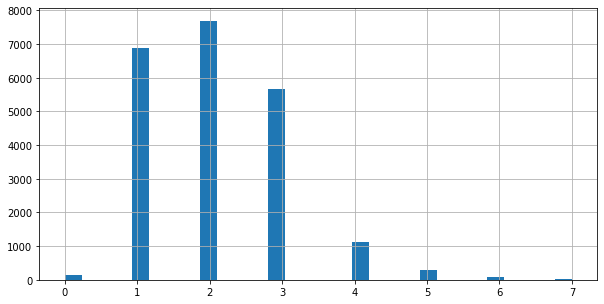

In [59]:
data['rooms'].hist(figsize=(10,5), bins=30)

Квартир с одной, двумя и тремя комнатами на рынке больше всего.\
6. Высота потолков

<AxesSubplot:>

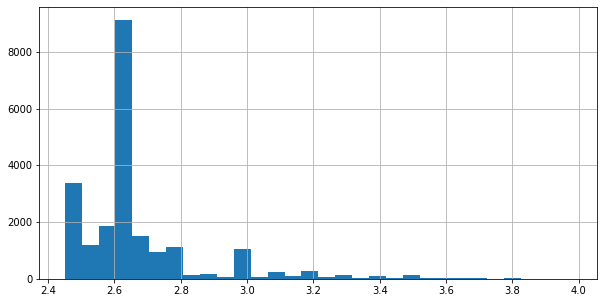

In [60]:
data['ceiling_height'].hist(figsize=(10,5), bins=30)

Больше всего объявлений на квартиры с высотой 2.6 метров.\
7. Этаж квартиры

<AxesSubplot:>

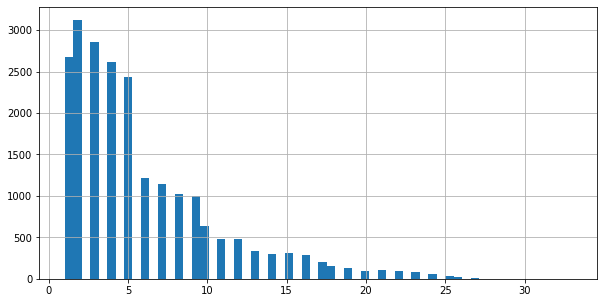

In [61]:
data['floor'].hist(figsize=(10,5), bins=60)

На рынке продается очень много квартир на первом этаже, а также со 2 по 5. Квартир на других этажах значительно меньше.\
8. Тип этажа квартиры

<AxesSubplot:>

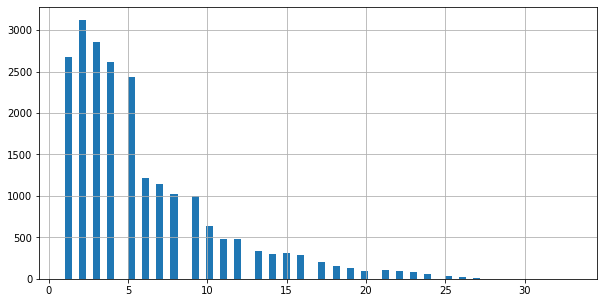

In [62]:
data['floor'].hist(figsize=(10,5), bins=72)

<AxesSubplot:>

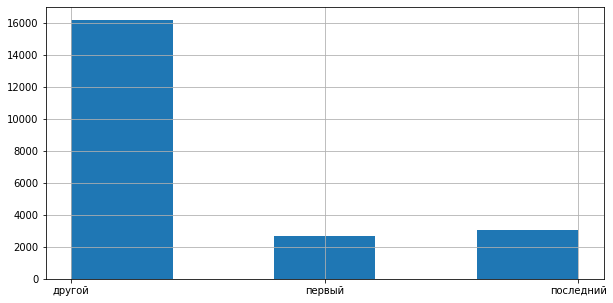

In [63]:
data['floor_type'].hist(figsize=(10,5), bins=5)

Здесь уже видно, что квартир на первых и последних этажах на рынке меньше, чем на других, что вполне логично.\
9. Общее количество этажей в доме

<AxesSubplot:>

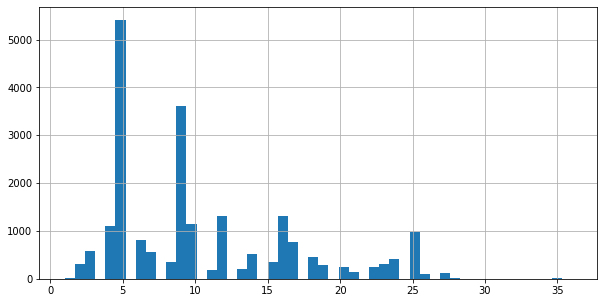

In [64]:
data['floors_total'].hist(figsize=(10,5), bins=50)

Большая доля рассматриваемых квартир находится в пятиэтажках и девятиэтажных домах.\
10. Расстояние до центра города в метрах

<AxesSubplot:>

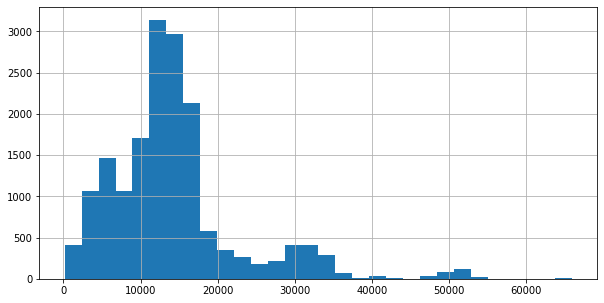

In [65]:
data['cityCenters_nearest'].hist(figsize=(10,5), bins=30)

Большинство квартир находится на расстоянии 10000-15000 м от центра города.\
11. Расстояние до ближайшего аэропорта

<AxesSubplot:>

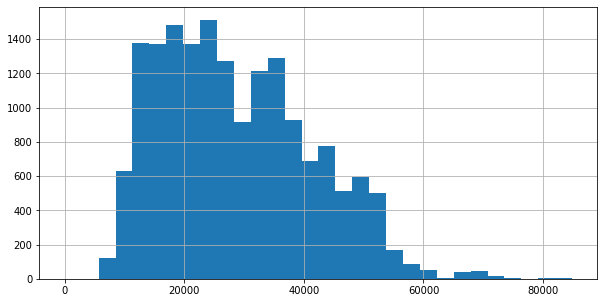

In [66]:
data['airports_nearest'].hist(figsize=(10,5), bins=30)

Аэропорт находится в 20 км от большинства выставленных на продажу квартир. Распределение расстояний до центра похоже на распределение Пуассона.\
12. Расстояние до ближайшего парка

<AxesSubplot:>

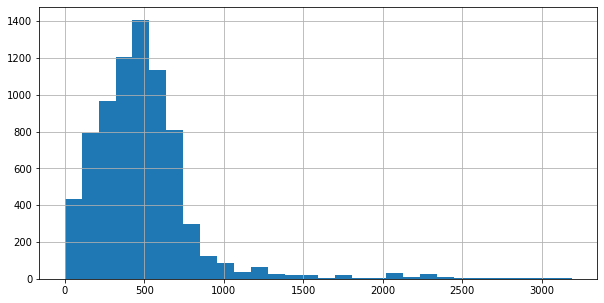

In [67]:
data['parks_nearest'].hist(figsize=(10,5), bins=30)

У большей части квартир парк находится на расстоянии 500 метров. Можно сказать, что почти у всех из представленных квартир в шаговой доступности (5-15 минут) есть парк.\
13. День публикации объявления

<AxesSubplot:>

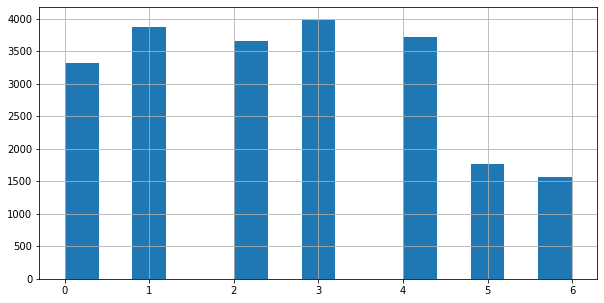

In [68]:
data['weekday'].hist(figsize=(10,5), bins=15)

Чаще всего квартиры выставляют на продажу в будни.\
14. Месяц публикации объявления

<AxesSubplot:>

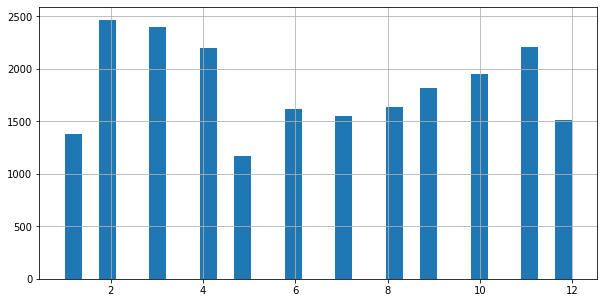

In [69]:
data['month'].hist(figsize=(10,5), bins=30)

Больше объявлений о продаже недвижимости в начале и в конце года, а именно фераль-март и октябрь-ноябрь.

**Рассмотрим как быстро продавались квартиры:**\
Построим гистограмму, показывающую, сколько дней было размещено каждое объявление

<AxesSubplot:>

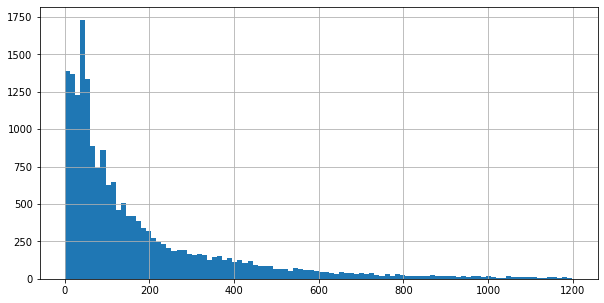

In [70]:
data['days_exposition'].hist(figsize=(10,5), bins=100)

По графику видно, что большая часть квартир продавалась менее, чем за 100 дней со дня подачи объявления. Случаев продажи объекта после 200 дней размещения объявления довольно мало.\
Подтвердим наши предположения и найдем среднее значение и медиану:

In [71]:
days_exposition_mean = data['days_exposition'].mean()
days_exposition_median = data['days_exposition'].median()
print('Среднее кол-во дней размещения объявления:', round(days_exposition_mean))
print('Медианное кол-во дней размещения объявления:', round(days_exposition_median))

Среднее кол-во дней размещения объявления: 176
Медианное кол-во дней размещения объявления: 95


Медианное значение отличается от среднего почти в два раза. Это можно объяснить тем, что есть объявления, которые были размещены более 4 лет, что является очень большой разницей с теми которые продавались за 3 месяца. Тем не менее, в большинство квартир размещены на сайте Яндекс Недвижимость около 100 дней, из-за чего медианное значение равно 96 дням. Продажи до 96 дней можно считать быстрыми, а те, которые "висят" на сайте больше-долгими. 

**Влияние факторов на конечную стоимость**\
**1. Зависимость цены от общей площади**

<AxesSubplot:xlabel='total_area'>

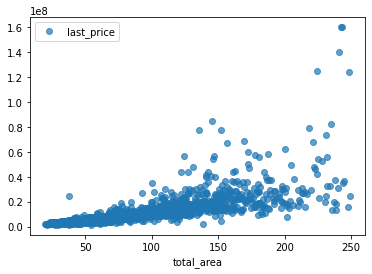

In [72]:
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(style='o', alpha=0.7)
)

Чем больше общая площадь квартиры, тем больше ее конечная цена. Найдем коэффициент корреляции, показывающий взаимосвязь двух величин:

In [73]:
data['total_area'].corr(data['last_price'])

0.7192339911950909

Корреляция положительная, то есть действительно большая площадь квартиры соответствует большей цене за нее.

**2. Зависимость цены от жилой площади**

<AxesSubplot:xlabel='living_area'>

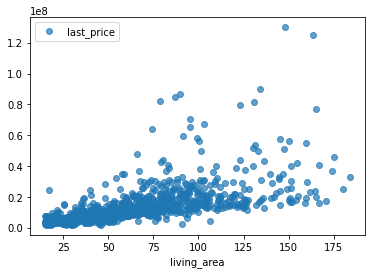

In [74]:
(
    data.pivot_table(index='living_area', values='last_price')
    .plot(style='o', alpha=0.7)
)

Цена растет с увеличением жилой площади, но не так значительно, как в предыдущем случае. Найдем корреляцию:

In [75]:
data['living_area'].corr(data['last_price'])

0.632178796920704

**3. Зависимость цены от площади кухни**

<AxesSubplot:xlabel='kitchen_area'>

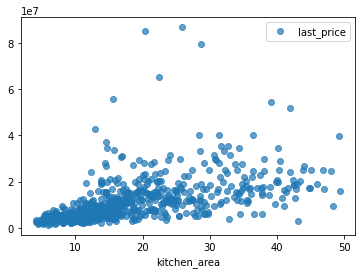

In [76]:
(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(style='o', alpha=0.7)
)

Здесь так же положительная корреляция, цена тем больше, чем больше площадь кухни.

In [77]:
data['kitchen_area'].corr(data['last_price'])

0.5315123650789345

**4. Зависимость цены от количества комнат**

<AxesSubplot:xlabel='rooms'>

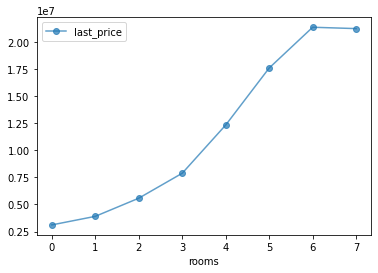

In [78]:
(
    data.pivot_table(index='rooms', values='last_price')
    .plot(style='o-', alpha=0.7)
)

In [79]:
data['rooms'].corr(data['last_price'])

0.428856762766338

Чем больше количество комнат, тем быстрее растет цена квартиры. Но если комнат более 6, то изменение цены меняет свой характер. 

**5. Зависимость цены от этажа квартиры**

<AxesSubplot:xlabel='floor_type'>

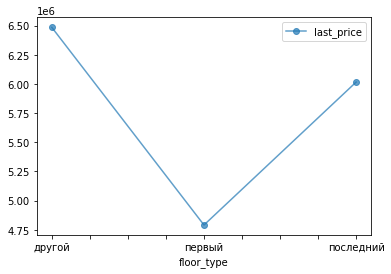

In [80]:
(
    data.pivot_table(index='floor_type', values='last_price')
    .plot(style='o-', alpha=0.7)
)

Квартиры на первом этаже имеют самую низкую цену. Квартиры на последнем и других этажах дороже.

**6. Зависимость цены от даты размещения**\
**6.1 День недели**

<AxesSubplot:xlabel='weekday'>

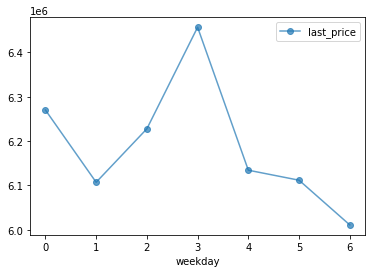

In [81]:
(
    data.pivot_table(index='weekday', values='last_price')
    .plot(style='o-', alpha=0.7)
)

In [82]:
data['weekday'].corr(data['last_price'])

-0.005904108540176944

Ничего не понятно. Можно сказать, что в среднем в начале недели цены на квартиры повышаются, а начиная с четверга, они становятся ниже.

**6.2. Месяц подачи объявления**

<AxesSubplot:xlabel='month'>

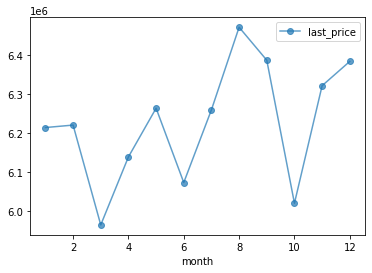

In [83]:
(
    data.pivot_table(index='month', values='last_price')
    .plot(style='o-', alpha=0.7)
)

In [84]:
data['month'].corr(data['last_price'])

0.010969818096897628

Еще больше непонятна связь. Цена то повышается, то понижается

**6.3 Год подачи объявления**

<AxesSubplot:xlabel='year'>

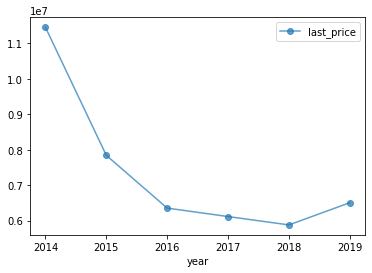

In [85]:
(
    data.pivot_table(index='year', values='last_price')
    .plot(style='o-', alpha=0.7)
)

In [86]:
data['year'].corr(data['last_price'])

-0.04832153650984017

Корреляция близка к 0, то есть влияние фактора "год" на конечную цену квартиры отсутствует. По графику заметна тенденция снижения цены на недвижимость до 2018 года, после 2018 цены начали расти. Чтобы понять такую закономерность необходимо изучить влияние других факторов, ведь, по факту, стоимость аналогичных квартир могла вести себя абсолютно иначе. Составим сводную таблицу по годам.

In [87]:
year_pivot = data.pivot_table(index='year', values=['total_area','last_price'], aggfunc=['count','mean'])
year_pivot.columns = ['count_price','count_area','mean_price','mean_area']
year_pivot

,count_price,count_area,mean_price,mean_area
year,,,,
2014,113,113,1.145561e+07,83.403451
2015,1039,1039,7.841152e+06,68.769827
2016,2579,2579,6.351112e+06,61.821241
2017,7616,7616,6.112598e+06,59.926614
2018,7864,7864,5.876701e+06,58.047246
2019,2692,2692,6.503622e+06,58.565431


<AxesSubplot:xlabel='year'>

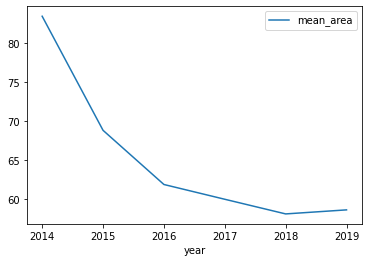

In [88]:
year_pivot.plot(y='mean_area')

По сводной таблице видно что пик размещения объявлений был в 2018 году, количество объявлений увеличилось практически в 400 раз с 2014 года. При этом видно, что средняя площадь продаваемых квартир снизилась почти в два раза. Этим можно объяснить то, что конечная стоимость квартир снижалась до 2018 года. Если бы мы рассматривали аналогичное количество объявлений и площади квартир результат был бы совсем другим.

**Найдем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

In [89]:
locality_name_pivot_table = data.pivot_table(index='locality_name', values='metеr_price', aggfunc=['count', 'mean'])
locality_name_pivot_table.columns = ['count','mean']
locality_name_pivot_table = locality_name_pivot_table.sort_values('count', ascending=False).head(10)
print(locality_name_pivot_table)

                 count           mean
locality_name                        
санкт-петербург  14753  112805.594780
мурино             476   84407.298975
кудрово            413   94301.172920
шушары             394   76944.355213
всеволожск         362   68554.764343
пушкин             344  102809.978797
колпино            327   75054.243801
гатчина            302   69084.927814
парголово          256   86987.809126
выборг             225   58574.987005


Для наглядности построим график:

<AxesSubplot:ylabel='locality_name'>

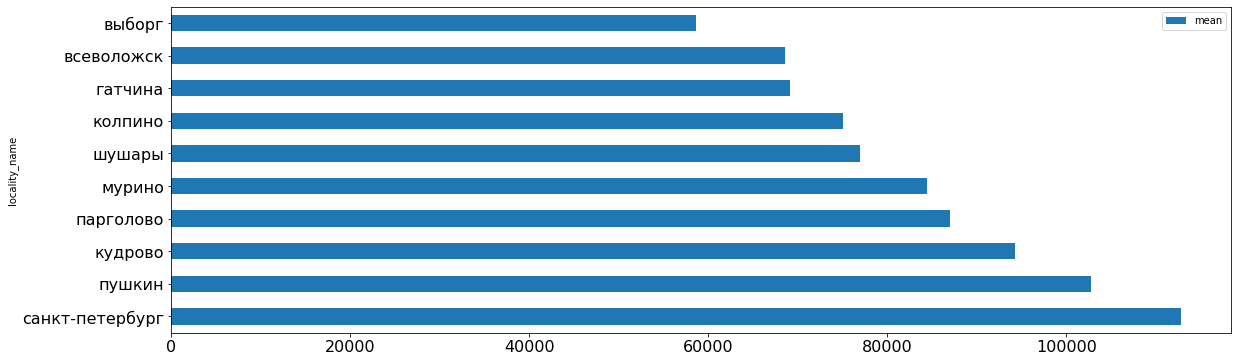

In [90]:
locality_name_pivot_table.sort_values('mean', ascending=False)\
.plot(kind = 'barh', y='mean', figsize = (19,6), fontsize = 16)

In [91]:
locality_name_pivot_table_max = locality_name_pivot_table[locality_name_pivot_table['mean'] == locality_name_pivot_table['mean'].max()]
print('Самая высокая цена за кв.м:', locality_name_pivot_table_max)
print()
locality_name_pivot_table_min = locality_name_pivot_table[locality_name_pivot_table['mean'] == locality_name_pivot_table['mean'].min()]
print('Самая низкая цена за кв.м:', locality_name_pivot_table_min)


Самая высокая цена за кв.м:                  count          mean
locality_name                       
санкт-петербург  14753  112805.59478

Самая низкая цена за кв.м:                count          mean
locality_name                     
выборг           225  58574.987005


Самая высокая цена за квадратный метр в Санкт-Петербурге, она составляет почти 113 тыс.рублей. Самая низкая цена из 10 населенных пунктов, в которых большее количество объявлений, в Всеволжске - почти 70 тыс.рублей за квадратный метр.

**Вычисление средней цены каждого километра от центра.\
Зависимость стоимости объектов от расстояния до центра города.**

In [92]:
centre_km_pivot =(
    data.query('locality_name == "санкт-петербург"')
    .pivot_table(index='centre_km', values='last_price', aggfunc='mean')
)
centre_km_pivot.head(20)

,last_price
centre_km,
0.0,2.239515e+07
1.0,1.609230e+07
2.0,1.546425e+07
3.0,1.043763e+07
4.0,1.135324e+07
5.0,1.196314e+07
6.0,1.240767e+07
7.0,1.362297e+07
8.0,9.043280e+06


Пока тяжело однозначно сказать, как влияет удаленность от центра города на цену квартиры. Построим график, чтобы нагляднее посмотреть на зависимость:

<AxesSubplot:xlabel='centre_km'>

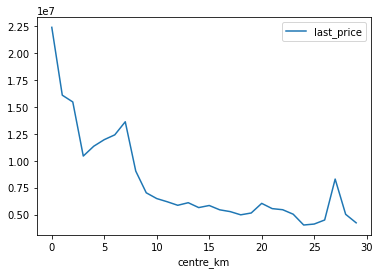

In [93]:
centre_km_pivot.plot()

В целом, можно сказать, что чем ближе квартира находится к центру, тем выше средняя цена каждого километра. Тем не менее, есть необъяснимые скачки в радиусе 6 км и 27 км. Это можно объяснить, что мы учитываем только фактор удаленности от центра. Возможно, в этом радиусе продаются большие и дорогие квартиры, цена которых сместила среднее значение. Рассмотрим такие случаи подробнее.

In [94]:
data_27km = (
    data.query('centre_km < 29 and centre_km > 20 and locality_name == "санкт-петербург"')
    .pivot_table(index='centre_km', values=['last_price', 'total_area'], aggfunc=['count','mean','max'])
)
data_27km.columns = ['count', 'count_area', 'mean_price', 'mean_area', 'max_price', 'max_area']
data_27km

,count,count_area,mean_price,mean_area,max_price,max_area
centre_km,,,,,,
21.0,113,113,5.555471e+06,59.241770,11620701.0,122.3
22.0,198,198,5.453138e+06,60.817626,16471698.0,187.3
23.0,82,82,5.037402e+06,57.419634,18250000.0,210.4
24.0,20,20,4.033258e+06,48.345500,5970000.0,82.0
25.0,23,23,4.121957e+06,48.091304,6200000.0,87.0
26.0,26,26,4.499950e+06,54.080769,7900000.0,100.0
27.0,2,2,8.300000e+06,53.000000,14350000.0,74.0
28.0,7,7,5.026429e+06,65.428571,7600000.0,111.0


Квартир, которые находятся в 27 км от центра города всего 2, что крайне мало среди общего числа рассматриваемых квартир. При этом средняя площадь квартир схожа с остальными. Бросается в глаза максимальная стоимость одной из квартир по заданному параметру, которая составляет 14,35 млн рублей. Вероятнее всего эта цена сместила среднее значение.

По графику так же заметен пик на 6-7 км и провал на 3 км от центра. Рассмотрим эти значения поподробнее:

In [95]:
data_centre = (
    data.query('centre_km < 8 and centre_km > 2 and locality_name == "санкт-петербург"')
    .pivot_table(index='centre_km', values=['last_price', 'total_area', 'rooms'], aggfunc=['count','mean','max'])
)
#data_centre.columns = ['count', 'count_area', 'mean_price', 'mean_area', 'max_price', 'max_area']
data_centre

count                           mean                       \
          last_price rooms total_area    last_price     rooms total_area   
centre_km                                                                  
3.0              323   323        323  1.043763e+07  2.969040  87.596904   
4.0              636   636        636  1.135324e+07  2.921384  88.841667   
5.0              826   826        826  1.196314e+07  2.746973  87.197143   
6.0              558   558        558  1.240767e+07  2.505376  82.078154   
7.0              392   392        392  1.362297e+07  2.438776  78.549566   

                   max                   
            last_price rooms total_area  
centre_km                                
3.0         82000000.0     7      248.0  
4.0        140000000.0     7      244.0  
5.0         98000000.0     7      239.0  
6.0         90000000.0     7      249.0  
7.0         86738800.0     6      237.8

Здесь так же видно, что максимальные цены квартир сильно влияют на среднее значение для конкретного клилометра от центра. Максимальная цена на 7 км почти в 2 раза больше чем на 3км. Это сильно повлияло на среднее значение, но пока непонятно почему, ведь средняя площадь квартир на 3 км даже больше чем на 7 и расстояние до центра меньше, что должно быть привлекательнее для потенциальных покупателей.

In [96]:
centre_3km = (
    data.query('centre_km == 3 and locality_name == "санкт-петербург"')
    .pivot_table(index='floor_type', values=['last_price'], aggfunc=['count','mean'])
)
centre_7km = (
    data.query('centre_km == 7 and locality_name == "санкт-петербург"')
    .pivot_table(index='floor_type', values=['last_price'], aggfunc=['count','mean'])
)
print(centre_3km)
print()
print(centre_7km)

                count          mean
           last_price    last_price
floor_type                         
другой            197  1.136279e+07
первый             52  7.575383e+06
последний          74  9.986002e+06

                count          mean
           last_price    last_price
floor_type                         
другой            304  1.438979e+07
первый             30  9.461857e+06
последний          58  1.175608e+07


В обоих случаях больше квартир на "другом" этаже, но средняя цена на них больше у квартир, находящихся в 7км от центра. Стоит отметить, что и остальные средние цены на квартиры на первом и последнем этажах так же больше на 7 км от центра. Квартир на "другом" этаже при этом 77% от общего числа, что больше чем у сравниваемой категории. Отсюда и разница в средних ценах за каждый километр от центра.

### Общий вывод

    В ходе проекта были изучены данные сервиса Яндекс Недвижимость. Была проведена предобработка данных, в которой:
-пропуски в столбце is_apartment были заменены на True\
-пропуски в столбце balcony были заменены на 0\
-пропуски в столбце с высотой квартиры были заменены медианным значением\
-кол-во парков и водоемов в радиусе 3км было так же заменено на 0\
-были изменены типы данных столбцов даты размещения объявлений и количества балконов\
-были удалены неявные дубликаты в названии населенных пунктов, а также аномальные значения по столбцам rooms, ceiling_height, living_area, total_area, kitchen_area, last_price, days_exposition, floors_total.

    В таблицу были добавлены новые столбцы: цена за кв.м, день недели, месяц и год размещения объявления, тип этажа и расстояние до центра в километрах.
    
    Был проведен исследовательский анализ данных на выявление зависимости различных факторов на конечную цену квартиры. Было выявлено, за сколько дней в среднем продается квартира. Результат-96 дней. Быстрыми продажами считаются те, срок размещения объявлений которых меньше этого числа, долгими- те, срок размещения которых больше 96 дней.
    
    Была изучена зависимость цены от общей площади, жилой площади, площади кухни, количества комнат, типа этажа квартиры и даты размещения объявления. Практически во всех случаев, за исключением типа этажа и даты размещения объявления, корреляция положительна, то есть цена растет пропорционально увеличению площади или количества комнат.
    
    Была найдена средняя цена одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений. Самая высокая цена за кв.м в Санкт-Петербурге, а самая низкая - в Всеволжске.
    
    Была так же вычислена средння цена каждого километра от центра Санкт-Петербурга. Оказалось, что средняя цена каждого километра все меньше при удалении от центра.
    
    Таким образом, можно сказать, что на цену квартиры влияет совокупность факторов, таких как, количество комнат, площадь квартиры, этаж, удаленность от центра и другие. 